# Thinking direct battery contro(continuous) No generator.

# Coding in progresss..... Quadratic running cost + Terminal Cost  



In [9]:
import numpy as np

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from scipy.stats import qmc

# Batch design parameters
sites = 512; batch = 20; nsim = sites * batch

# parameters

maturity = 24 * 2 # units are in hours
global dt; dt = 15/60;
nstep = int(maturity/dt)
print(nstep)
n_sim = 10000
# using same noise below


192


In [10]:
def demandSimulate(α, m, σ, n_step, n_sim, maturity, P0,given_W = False, W = None):
    
    dt = maturity/n_step
    priceMatrix = np.zeros((n_sim, n_step+1))
    priceMatrix[:,0] = np.ones(n_sim) * P0
    
    if not given_W:
        dW = np.random.normal(0,1,size = (n_sim,n_step) ) * np.sqrt(dt)
    
    else:
        dW = W
    
    
    for i in range(1,n_step+1):
        priceMatrix[:,i] = priceMatrix[:,i-1] + α * (m - priceMatrix[:,i-1]) * dt + σ * dW[:,i-1]
        
    return priceMatrix

In [11]:
Xs = demandSimulate(0.5,0,2,nstep,n_sim,48,0,given_W = False, W = None)

Running cost is quadractic. 


$ dX_t = \alpha (m- X_t)dt +\sigma dt$   
$ dI_t = B_t dt$

$\alpha = 0.5, m = 0, \sigma = 2 $

$I_{max} = 10(kWh), B_{range} = [-6,6]$

T = 48 hours, $\Delta t  = 0.25$hr
$V(0,I_0,B_0) = E[\int_0^T (B_t+ X_t)^2dt + g(I_T)]$  
$B_t$ is uncontrolled here.

In [12]:
B_min = -6
B_max = 6
I_max = 10

In [61]:
def V(I0,given_W = False, W = None,):
    X0 = 0

    #Xt = demandSimulate(0.5,0,2,nstep,n_sim,48,X0,given_W = False, W = None)
    Xt = Xs
    Bt = np.zeros((n_sim,nstep+1))
    It = np.zeros((n_sim,nstep+1))
    It[:,0] = I0
    diff = np.zeros((n_sim,nstep+1))
    
    for i in range(0,nstep):    
        constraint1 = np.maximum(B_min, -Xt[:,i])
        constraint2 = np.minimum(constraint1,B_max)
        constraint3 = np.minimum(constraint2, (I_max - It[:,i])/dt)
        #Bt in 2D
        Bt[:,i] = np.maximum(-It[:,i]/dt, constraint3)
        It[:,i+1] = It[:,i] + Bt[:,i]* dt
        diff[:,i] = Bt[:,i]+Xt[:,i] 

    final_cost = 200 * np.maximum(I0-It[:,-1],0)
    running_cost =  np.sum((Bt+Xt)**2 *dt,axis = 1)
    total_cost = np.mean(running_cost+final_cost)
    return total_cost,Bt[0,:],It[0,:],Xt[0,:],diff[0,:]
     

In [62]:
V(5)[0]

464.255860614011

In [36]:
I_range = np.arange(0,10,0.01)
cost = np.zeros(len(I_range))
for i in range(len(I_range)):
    cost[i] = V(I_range[i])[0]

KeyboardInterrupt: 

In [ ]:
plt.plot(I_range,cost)

In [21]:
cost,B,I,X,diff = V(5)


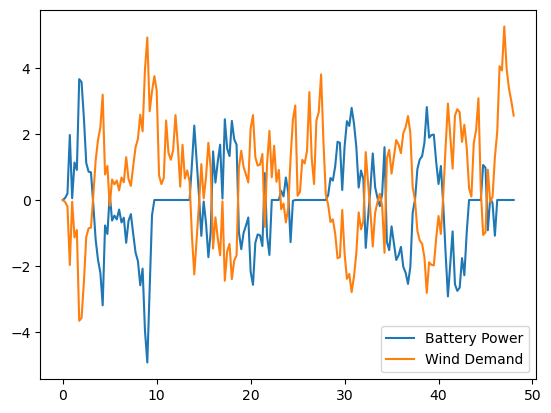

In [22]:
import matplotlib.pyplot as plt
t = np.linspace(0,48,193)
plt.plot(t,B)
plt.plot(t,X)
plt.legend(["Battery Power","Wind Demand" ])

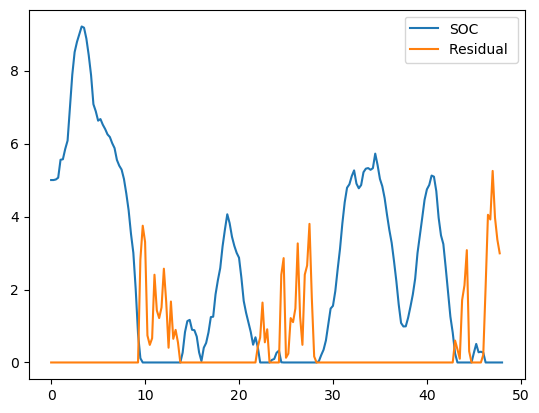

In [23]:
plt.plot(t,I)
plt.plot(t[:-1],diff[:-1])
plt.legend(["SOC","Residual " ])